# Visual Transformer 

Training Visual Transformer on CROPS

In [1]:
pip -q install vit_pytorch linformer

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu111


In [4]:
# Training settings
batch_size = 2
epochs = 50
lr = 3e-5
gamma = 0.7
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
device = 'cuda'

## Load Data

In [7]:
os.makedirs('data', exist_ok=True)

In [8]:
train_dir = 'data/train'
test_dir = 'data/test'

In [9]:
train_list = glob.glob(os.path.join(train_dir,'*/*.png'))
test_list = glob.glob(os.path.join(test_dir, '*/*.png'))

In [10]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 3600
Test Data: 920


In [11]:
labels = [os.path.split(os.path.split(path)[0])[1] for path in train_list]
#print(labels)

## Random Plots

3600
[3175 3508  861 1295 1131 1096 3093 1639 2170]


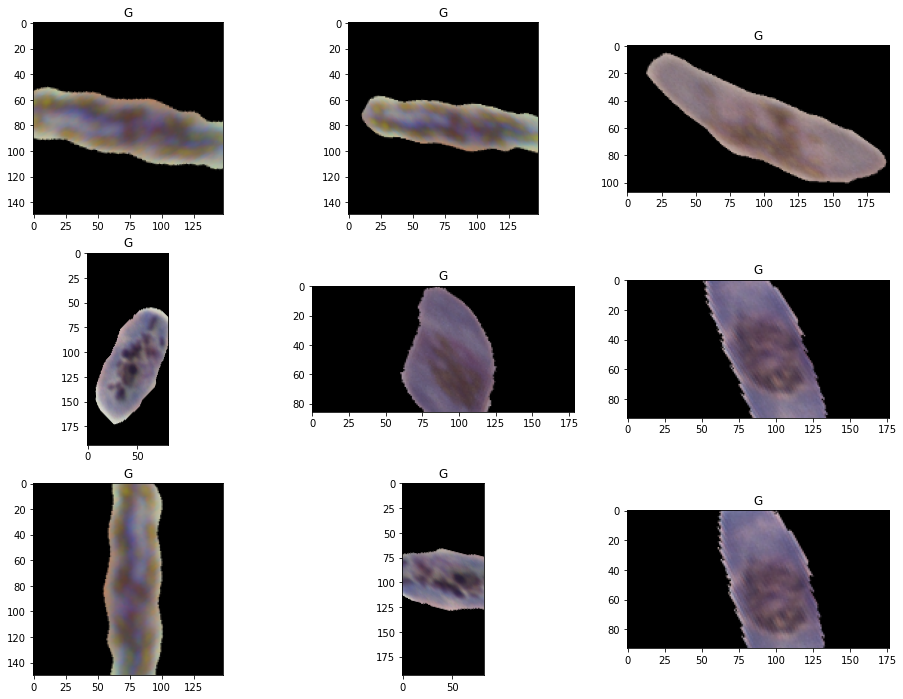

In [12]:
print(len(train_list))
random_idx = np.random.randint(1, len(train_list), size=9)
print(random_idx)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [13]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [14]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 2880
Validation Data: 720
Test Data: 920


## Image Augumentation

In [15]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [16]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = os.path.split(os.path.split(img_path)[0])[1]
        if label == 'G':
            label=0
        elif label == 'R':
            label=1
        elif label == 'S':
            label=2
        elif label == 'T':
            label=3
        #print("LA LABEL E ",label)
  
       
        return img_transformed, label


In [17]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [19]:
print(len(train_data), len(train_loader))

2880 1440


In [20]:
print(len(valid_data), len(valid_loader))

720 360


In [21]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [22]:
torch.cuda.empty_cache()

In [23]:
from vit_pytorch.cross_vit import CrossViT

model = CrossViT(
    image_size = 224,
    num_classes = 4,
    depth = 4,               # number of multi-scale encoding blocks
    sm_dim = 192,            # high res dimension
    sm_patch_size = 16,      # high res patch size (should be smaller than lg_patch_size)
    sm_enc_depth = 2,        # high res depth
    sm_enc_heads = 8,        # high res heads
    sm_enc_mlp_dim = 2048,   # high res feedforward dimension
    lg_dim = 384,            # low res dimension
    lg_patch_size = 32,      # low res patch size
    lg_enc_depth = 3,        # low res depth
    lg_enc_heads = 8,        # low res heads
    lg_enc_mlp_dim = 2048,   # low res feedforward dimensions
    cross_attn_depth = 2,    # cross attention rounds
    cross_attn_heads = 8,    # cross attention heads
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

### Training

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [25]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):



        
        data = data.to(device)
        label = label.to(device)
        
        
        
        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    filename="./trained_models/pretrained_net"+str(epoch)+".pt"
    torch.save(model.state_dict(), filename)


  0%|          | 0/1440 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(), 'pretrained-net1.pt')

In [ ]:
print("Predictions: ")

for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.cpu()
        output = model(data).max(1).indices
        print("Predicticted: ",output, "  Label: ",label)
